Sesión 15: Integración de Datos de Múltiples Fuentes
Demo 03: Homogeneización de Datos

Este demo demuestra técnicas para estandarizar y homogeneizar datos
de diferentes fuentes con formatos, unidades y frecuencias distintas.

Autor: AdP Meridian Consulting
Fecha: 2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import interpolate
import warnings
warnings.filterwarnings('ignore')

## 1. CREACIÓN DE FUENTES CON DIFERENTES FORMATOS

### Creando FUENTE A - Datos Horarios SCADA:

In [2]:
fechas_horarias = pd.date_range('2024-01-01 00:00', '2024-01-03 23:00', freq='H')
np.random.seed(42)

fuente_a = []
for timestamp in fechas_horarias:
    # Variación diaria de producción (más alta durante el día)
    hora = timestamp.hour
    factor_horario = 0.8 + 0.4 * np.sin((hora - 6) * np.pi / 12) if 6 <= hora <= 18 else 0.6
    
    fuente_a.append({
        'timestamp': timestamp,
        'pozo': 'PZ-001',  # Formato diferente de ID
        'oil_rate_bpd': 150 * factor_horario + np.random.normal(0, 5),
        'gas_rate_mcfd': 1250 * factor_horario + np.random.normal(0, 50),
        'wellhead_pressure_psia': 580 + np.random.normal(0, 15),
        'temperature_fahrenheit': 149 + np.random.normal(0, 5),  # En Fahrenheit
        'fuente': 'SCADA_HORARIO'
    })

df_fuente_a = pd.DataFrame(fuente_a)
print(f"  - Registros: {len(df_fuente_a)}")
print(f"  - Frecuencia: Horaria")
print(f"  - Unidades: °F, psia, mcfd")
print()

  - Registros: 72
  - Frecuencia: Horaria
  - Unidades: °F, psia, mcfd



### Creando FUENTE B - Reportes Diarios:

In [3]:
fechas_diarias = pd.date_range('2024-01-01', '2024-01-07', freq='D')

fuente_b = []
for fecha in fechas_diarias:
    fuente_b.append({
        'date': fecha.strftime('%d/%m/%Y'),  # Formato DD/MM/YYYY
        'well_id': 'Pozo_001',  # Otro formato de ID
        'crude_production_bbl': 150 * 24 + np.random.normal(0, 200),  # Barriles totales del día
        'gas_production_mscf': 1.25 + np.random.normal(0, 0.1),  # En miles de pies cúbicos
        'avg_pressure_psig': 565 + np.random.normal(0, 20),  # Presión gauge
        'max_temp_celsius': 65 + np.random.normal(0, 3),
        'operating_hours': np.random.uniform(20, 24),  # Horas operativas del día
        'fuente': 'REPORTES_DIARIOS'
    })

df_fuente_b = pd.DataFrame(fuente_b)
df_fuente_b['date'] = pd.to_datetime(df_fuente_b['date'], format='%d/%m/%Y')
print(f"  - Registros: {len(df_fuente_b)}")
print(f"  - Frecuencia: Diaria")
print(f"  - Unidades: °C, psig, mscf, bbl totales")
print()

  - Registros: 7
  - Frecuencia: Diaria
  - Unidades: °C, psig, mscf, bbl totales



### Creando FUENTE C - Análisis de Laboratorio:

In [4]:
fechas_4h = pd.date_range('2024-01-01 06:00', '2024-01-05 18:00', freq='4H')

fuente_c = []
for timestamp in fechas_4h:
    fuente_c.append({
        'sampling_datetime': timestamp,
        'well_identifier': '001',  # Solo número
        'oil_gravity_api': 32.5 + np.random.normal(0, 1),
        'water_cut_percent': 15 + np.random.normal(0, 3),
        'gas_oil_ratio': 833 + np.random.normal(0, 50),  # scf/bbl
        'sample_temperature_k': 338 + np.random.normal(0, 2),  # En Kelvin
        'fuente': 'LABORATORIO_4H'
    })

df_fuente_c = pd.DataFrame(fuente_c)
print(f"  - Registros: {len(df_fuente_c)}")
print(f"  - Frecuencia: Cada 4 horas")
print(f"  - Unidades: °K, API, %, scf/bbl")
print()

  - Registros: 28
  - Frecuencia: Cada 4 horas
  - Unidades: °K, API, %, scf/bbl



## 2. NORMALIZACIÓN DE IDENTIFICADORES DE POZOS

In [6]:
mapeo_pozos = {
    'PZ-001': 'PZ001',
    'Pozo_001': 'PZ001', 
    '001': 'PZ001'
}
print("✓ Mapeo de identificadores:")
for original, normalizado in mapeo_pozos.items():
    print(f"  '{original}' → '{normalizado}'")

✓ Mapeo de identificadores:
  'PZ-001' → 'PZ001'
  'Pozo_001' → 'PZ001'
  '001' → 'PZ001'


In [7]:
# Aplicar normalización
df_fuente_a['pozo_id'] = df_fuente_a['pozo'].map(mapeo_pozos)
df_fuente_b['pozo_id'] = df_fuente_b['well_id'].map(mapeo_pozos)
df_fuente_c['pozo_id'] = df_fuente_c['well_identifier'].map(mapeo_pozos)

print(f"\n✓ IDs normalizados correctamente en todas las fuentes")
print()


✓ IDs normalizados correctamente en todas las fuentes



## 3. HOMOGENEIZACIÓN DE UNIDADES

In [9]:
print("✓ Conversiones de unidades aplicadas:")

# Fuente A: Fahrenheit → Celsius
df_fuente_a['temperatura_c'] = (df_fuente_a['temperature_fahrenheit'] - 32) * 5/9
print("  • Fahrenheit → Celsius")

# Fuente A: psia → psig (restar presión atmosférica ~14.7 psi)
df_fuente_a['presion_psig'] = df_fuente_a['wellhead_pressure_psia'] - 14.7
print("  • psia → psig")

# Fuente A: mcfd → mscf (dividir por 1000)
df_fuente_a['gas_mscf'] = df_fuente_a['gas_rate_mcfd'] / 1000
print("  • mcfd → mscf")

# Fuente B: Ya está en unidades correctas, solo ajustar presión
df_fuente_b['presion_psia'] = df_fuente_b['avg_pressure_psig'] + 14.7
print("  • psig → psia")

# Fuente C: Kelvin → Celsius
df_fuente_c['temperatura_c'] = df_fuente_c['sample_temperature_k'] - 273.15
print("  • Kelvin → Celsius")

print()
print(df_fuente_c['temperatura_c'].head())

✓ Conversiones de unidades aplicadas:
  • Fahrenheit → Celsius
  • psia → psig
  • mcfd → mscf
  • psig → psia
  • Kelvin → Celsius

0    62.456679
1    64.832366
2    66.457626
3    65.257645
4    63.895237
Name: temperatura_c, dtype: float64


In [10]:
# Crear tabla de conversiones para referencia
conversiones = pd.DataFrame({
    'Parámetro': ['Temperatura', 'Presión', 'Gas', 'Volumen'],
    'Unidad_Original': ['°F, K', 'psia, psig', 'mcfd, mscf', 'bbl, bpd'],
    'Unidad_Estándar': ['°C', 'psia', 'mscf', 'bpd'],
    'Factor_Conversión': ['(°F-32)*5/9, K-273.15', 'psig+14.7, psia-14.7', '/1000, *1000', '1, /24']
})

print("✓ Tabla de conversiones utilizadas:")
print(conversiones.to_string(index=False))
print()

✓ Tabla de conversiones utilizadas:
  Parámetro Unidad_Original Unidad_Estándar     Factor_Conversión
Temperatura           °F, K              °C (°F-32)*5/9, K-273.15
    Presión      psia, psig            psia  psig+14.7, psia-14.7
        Gas      mcfd, mscf            mscf          /1000, *1000
    Volumen        bbl, bpd             bpd                1, /24



## 4. ESTANDARIZACIÓN DE FRECUENCIAS TEMPORALES

In [11]:
# Objetivo: Crear series temporales diarias uniformes
print("✓ Convertir todas las fuentes a frecuencia diaria:")

# Fuente A (horaria → diaria): Promediar por día
fuente_a_diaria = df_fuente_a.groupby(df_fuente_a['timestamp'].dt.date).agg({
    'oil_rate_bpd': 'mean',
    'gas_mscf': 'mean',
    'presion_psig': 'mean',
    'temperatura_c': 'mean',
    'pozo_id': 'first'
}).reset_index()

fuente_a_diaria['fecha'] = pd.to_datetime(fuente_a_diaria['timestamp'])
fuente_a_diaria['fuente'] = 'SCADA_DIARIO'
print(f"  • SCADA: {len(df_fuente_a)} registros horarios → {len(fuente_a_diaria)} registros diarios")


✓ Convertir todas las fuentes a frecuencia diaria:
  • SCADA: 72 registros horarios → 3 registros diarios


In [12]:
# Fuente B (diaria): Ya está en formato correcto
fuente_b_diaria = df_fuente_b.copy()
fuente_b_diaria['fecha'] = fuente_b_diaria['date']
fuente_b_diaria['oil_rate_bpd'] = fuente_b_diaria['crude_production_bbl'] / 1  # Ya es diario
fuente_b_diaria['gas_mscf'] = fuente_b_diaria['gas_production_mscf'] 
fuente_b_diaria['temperatura_c'] = fuente_b_diaria['max_temp_celsius']
print(f"  • Reportes: {len(fuente_b_diaria)} registros diarios (sin cambios)")


  • Reportes: 7 registros diarios (sin cambios)


In [13]:
# Fuente C (4 horas → diaria): Interpolar valores faltantes
print("  • Laboratorio: Interpolando valores cada 4h → diarios")

# Crear rango completo de fechas diarias
fecha_inicio = df_fuente_c['sampling_datetime'].min().date()
fecha_fin = df_fuente_c['sampling_datetime'].max().date()
fechas_completas = pd.date_range(fecha_inicio, fecha_fin, freq='D')

# Resamplear a diario con interpolación
df_fuente_c_indexed = df_fuente_c.set_index('sampling_datetime')
print("columans c")
print(df_fuente_c_indexed.dtypes)
cols_numericas = ['oil_gravity_api', 'water_cut_percent', 'gas_oil_ratio', 'sample_temperature_k','temperatura_c']

fuente_c_diaria = df_fuente_c_indexed[cols_numericas].resample('D').mean()
fuente_c_diaria = fuente_c_diaria.interpolate(method='linear')
fuente_c_diaria.reset_index(inplace=True)
fuente_c_diaria['fecha'] = fuente_c_diaria['sampling_datetime']
fuente_c_diaria['pozo_id'] = 'PZ001'
fuente_c_diaria['fuente'] = 'LABORATORIO_DIARIO'
print(f"    Registros resultantes: {len(fuente_c_diaria)}")
print()

  • Laboratorio: Interpolando valores cada 4h → diarios
columans c
well_identifier          object
oil_gravity_api         float64
water_cut_percent       float64
gas_oil_ratio           float64
sample_temperature_k    float64
fuente                   object
pozo_id                  object
temperatura_c           float64
dtype: object
    Registros resultantes: 5



## 5. ALINEACIÓN TEMPORAL DE SERIES

In [15]:
# Encontrar período común
inicio_comun = max(
    fuente_a_diaria['fecha'].min(),
    fuente_b_diaria['fecha'].min(), 
    fuente_c_diaria['fecha'].min()
)
fin_comun = min(
    fuente_a_diaria['fecha'].max(),
    fuente_b_diaria['fecha'].max(),
    fuente_c_diaria['fecha'].max()
)

print(f"✓ Período común identificado: {inicio_comun.date()} a {fin_comun.date()}")

# Filtrar todas las fuentes al período común
fuente_a_alineada = fuente_a_diaria[
    (fuente_a_diaria['fecha'] >= inicio_comun) & 
    (fuente_a_diaria['fecha'] <= fin_comun)
].copy()

fuente_b_alineada = fuente_b_diaria[
    (fuente_b_diaria['fecha'] >= inicio_comun) & 
    (fuente_b_diaria['fecha'] <= fin_comun)
].copy()

fuente_c_alineada = fuente_c_diaria[
    (fuente_c_diaria['fecha'] >= inicio_comun) & 
    (fuente_c_diaria['fecha'] <= fin_comun)
].copy()

print("=============================FUENTE C=================================================")
print(fuente_c_alineada.columns)
print("==============================================================================")
print(f"  • Registros alineados: A={len(fuente_a_alineada)}, B={len(fuente_b_alineada)}, C={len(fuente_c_alineada)}")
print()


✓ Período común identificado: 2024-01-01 a 2024-01-03
=============================FUENTE C=================================================
Index(['sampling_datetime', 'oil_gravity_api', 'water_cut_percent',
       'gas_oil_ratio', 'sample_temperature_k', 'temperatura_c', 'fecha',
       'pozo_id', 'fuente'],
      dtype='object')
  • Registros alineados: A=3, B=3, C=3



## 6. INTEGRACIÓN DE ESQUEMAS DE DATOS

In [16]:
# Definir esquema común
esquema_comun = {
    'fecha': 'datetime64[ns]',
    'pozo_id': 'object',
    'produccion_crudo_bpd': 'float64',
    'presion_cabeza_psia': 'float64', 
    'temperatura_c': 'float64',
    'fuente': 'object'
}

print("✓ Esquema común definido:")
for campo, tipo in esquema_comun.items():
    print(f"  • {campo}: {tipo}")
print()

# Crear datasets con esquema común
print("✓ Aplicando esquema común:")

print(fuente_c_alineada.columns)
print(fuente_c_alineada['temperatura_c'])
# Fuente A
df_a_comun = pd.DataFrame()

df_a_comun['fecha'] = fuente_a_alineada['fecha']
df_a_comun['pozo_id'] = fuente_a_alineada['pozo_id']
df_a_comun['produccion_crudo_bpd'] = fuente_a_alineada['oil_rate_bpd']
df_a_comun['presion_cabeza_psia'] = fuente_a_alineada['presion_psig'] + 14.7  # Convertir de psig
df_a_comun['temperatura_c'] = fuente_a_alineada['temperatura_c']
df_a_comun['fuente'] = 'SCADA'
print(f"  • Fuente A homogeneizada: {len(df_a_comun)} registros")

# Fuente B
df_b_comun = pd.DataFrame()
df_b_comun['fecha'] = fuente_b_alineada['fecha']
df_b_comun['pozo_id'] = fuente_b_alineada['pozo_id']
df_b_comun['produccion_crudo_bpd'] = fuente_b_alineada['oil_rate_bpd']
df_b_comun['presion_cabeza_psia'] = fuente_b_alineada['presion_psia']
df_b_comun['temperatura_c'] = fuente_b_alineada['temperatura_c']
df_b_comun['fuente'] = 'REPORTES'
print(f"  • Fuente B homogeneizada: {len(df_b_comun)} registros")

# Para Fuente C: Solo agregar campos disponibles
df_c_comun = pd.DataFrame()
df_c_comun['fecha'] = fuente_c_alineada['fecha']
df_c_comun['pozo_id'] = fuente_c_alineada['pozo_id']
df_c_comun['produccion_crudo_bpd'] = np.nan  # No disponible en lab
df_c_comun['presion_cabeza_psia'] = np.nan   # No disponible en lab
df_c_comun['temperatura_c'] = fuente_c_alineada['temperatura_c']
df_c_comun['fuente'] = 'LABORATORIO'
print(f"  • Fuente C homogeneizada: {len(df_c_comun)} registros")
print()

✓ Esquema común definido:
  • fecha: datetime64[ns]
  • pozo_id: object
  • produccion_crudo_bpd: float64
  • presion_cabeza_psia: float64
  • temperatura_c: float64
  • fuente: object

✓ Aplicando esquema común:
Index(['sampling_datetime', 'oil_gravity_api', 'water_cut_percent',
       'gas_oil_ratio', 'sample_temperature_k', 'temperatura_c', 'fecha',
       'pozo_id', 'fuente'],
      dtype='object')
0    64.579911
1    66.177568
2    65.213917
Name: temperatura_c, dtype: float64
  • Fuente A homogeneizada: 3 registros
  • Fuente B homogeneizada: 3 registros
  • Fuente C homogeneizada: 3 registros



## 7. COMBINACIÓN E INTEGRACIÓN FINAL

In [17]:
# Combinar todos los datasets
dataset_integrado = pd.concat([df_a_comun, df_b_comun, df_c_comun], 
                             ignore_index=True, sort=False)

print(f"✓ Dataset integrado creado: {len(dataset_integrado)} registros totales")
print(f"  • Período: {dataset_integrado['fecha'].min().date()} a {dataset_integrado['fecha'].max().date()}")
print(f"  • Fuentes: {sorted(dataset_integrado['fuente'].unique())}")
print()

# Crear vista consolidada por fecha (un registro por día)
print("✓ Creando vista consolidada por fecha:")
consolidado = dataset_integrado.groupby('fecha').agg({
    'pozo_id': 'first',
    'produccion_crudo_bpd': lambda x: x.dropna().mean() if len(x.dropna()) > 0 else np.nan,
    'presion_cabeza_psia': lambda x: x.dropna().mean() if len(x.dropna()) > 0 else np.nan,
    'temperatura_c': lambda x: x.dropna().mean() if len(x.dropna()) > 0 else np.nan,
    'fuente': lambda x: '+'.join(sorted(x.dropna().unique()))
}).reset_index()

print(f"  • Registros consolidados: {len(consolidado)}")
print(f"  • Valores promediados cuando múltiples fuentes disponibles")
print()

# Mostrar ejemplo del resultado
print("✓ Muestra del dataset consolidado:")
print(consolidado.head().to_string(index=False))
print()

✓ Dataset integrado creado: 9 registros totales
  • Período: 2024-01-01 a 2024-01-03
  • Fuentes: ['LABORATORIO', 'REPORTES', 'SCADA']

✓ Creando vista consolidada por fecha:
  • Registros consolidados: 3
  • Valores promediados cuando múltiples fuentes disponibles

✓ Muestra del dataset consolidado:
     fecha pozo_id  produccion_crudo_bpd  presion_cabeza_psia  temperatura_c                     fuente
2024-01-01   PZ001           1890.313865           576.769753      64.421076 LABORATORIO+REPORTES+SCADA
2024-01-02   PZ001           1800.402660           588.089735      66.953510 LABORATORIO+REPORTES+SCADA
2024-01-03   PZ001           1944.250214           571.919617      64.463142 LABORATORIO+REPORTES+SCADA



## 8. VALIDACIÓN DE CALIDAD DESPUÉS DE HOMOGENEIZACIÓN

In [18]:
print("✓ Métricas de completitud:")
total_registros = len(consolidado)
for columna in ['produccion_crudo_bpd', 'presion_cabeza_psia', 'temperatura_c']:
    valores_validos = consolidado[columna].notna().sum()
    pct_completo = valores_validos / total_registros * 100
    print(f"  • {columna}: {valores_validos}/{total_registros} ({pct_completo:.1f}%)")
print()

print("✓ Rangos de valores después de homogeneización:")
for columna in ['produccion_crudo_bpd', 'presion_cabeza_psia', 'temperatura_c']:
    serie = consolidado[columna].dropna()
    if len(serie) > 0:
        print(f"  • {columna}: {serie.min():.1f} - {serie.max():.1f} (media: {serie.mean():.1f})")
print()

# Verificar consistencia temporal
print("✓ Verificación de consistencia temporal:")
fechas_ordenadas = consolidado['fecha'].sort_values()
gaps = fechas_ordenadas.diff().dt.days
print(f"  • Gaps temporales detectados: {(gaps > 1).sum()}")
if (gaps > 1).sum() > 0:
    print(f"  • Gap máximo: {gaps.max()} días")
print()

✓ Métricas de completitud:
  • produccion_crudo_bpd: 3/3 (100.0%)
  • presion_cabeza_psia: 3/3 (100.0%)
  • temperatura_c: 3/3 (100.0%)

✓ Rangos de valores después de homogeneización:
  • produccion_crudo_bpd: 1800.4 - 1944.3 (media: 1878.3)
  • presion_cabeza_psia: 571.9 - 588.1 (media: 578.9)
  • temperatura_c: 64.4 - 67.0 (media: 65.3)

✓ Verificación de consistencia temporal:
  • Gaps temporales detectados: 0



## 9. VISUALIZACIÓN DE RESULTADOS

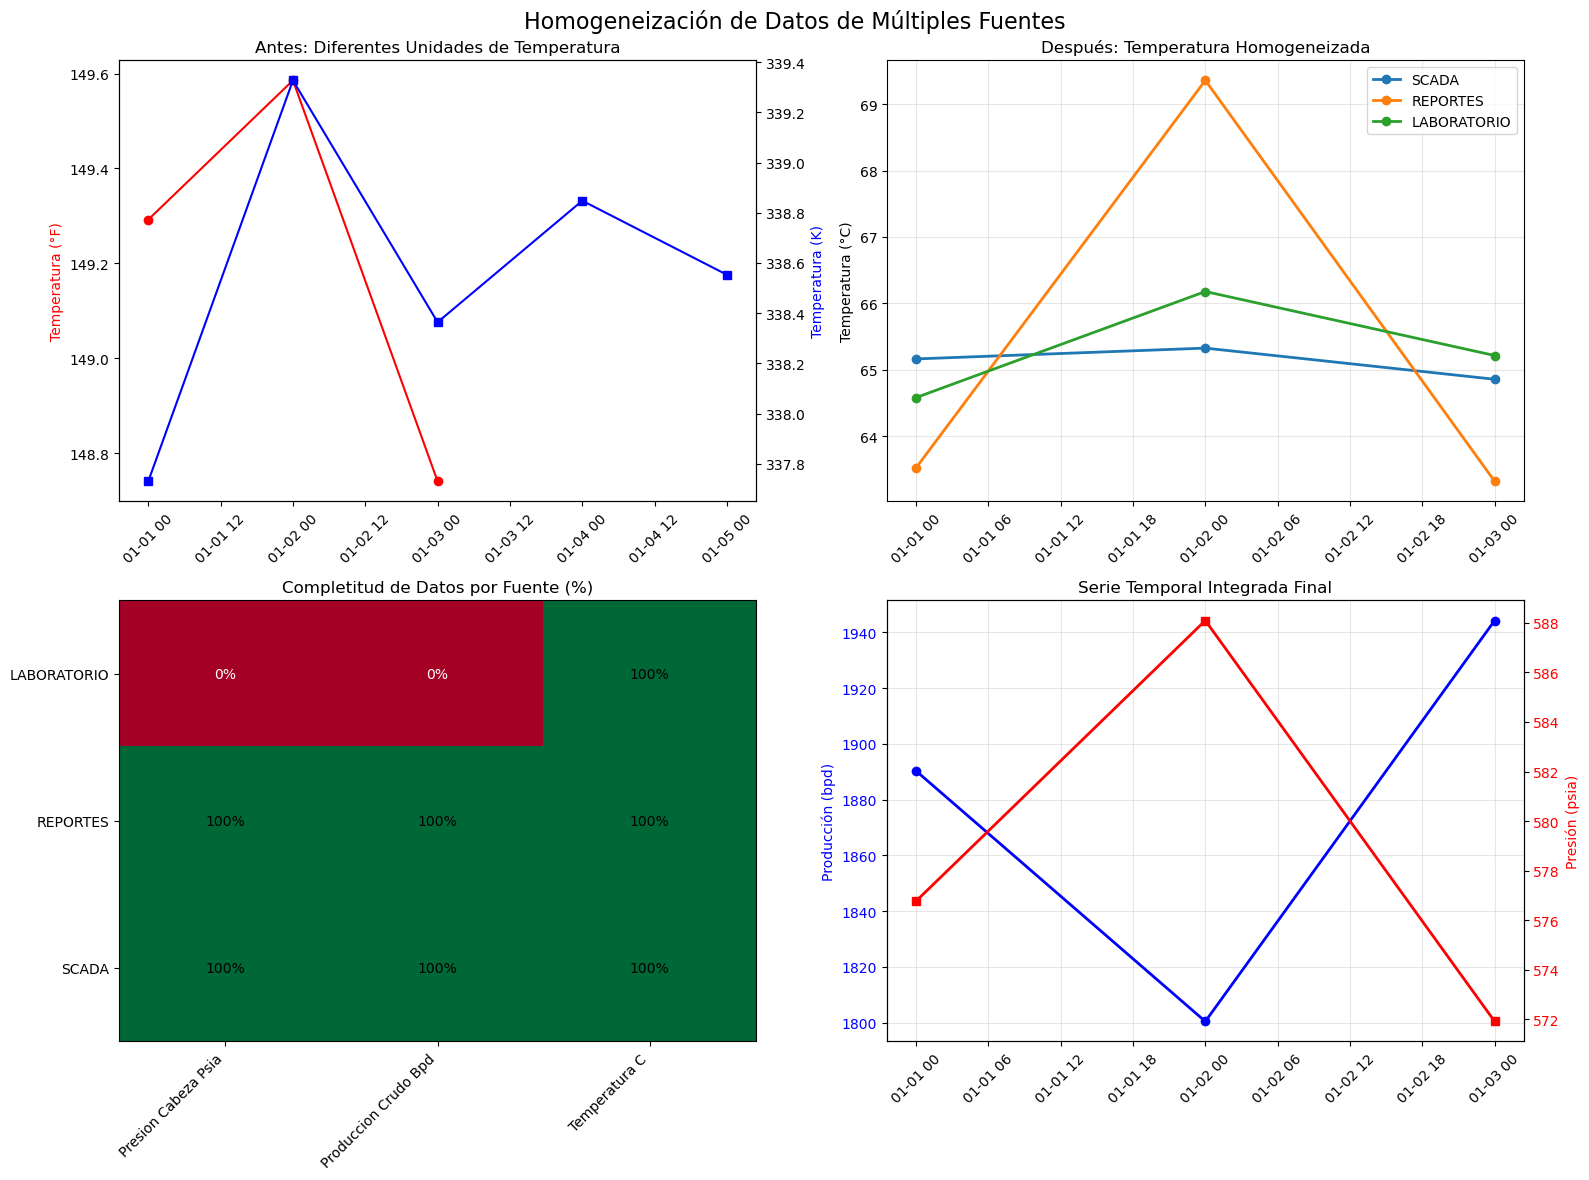

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Homogeneización de Datos de Múltiples Fuentes', fontsize=16, y=0.98)

# Gráfico 1: Comparación de temperaturas antes y después
ax1 = axes[0, 0]
if not df_fuente_a.empty and not df_fuente_c.empty:
    # Antes: temperaturas en diferentes unidades
    ax1_twin = ax1.twinx()
    
    fechas_a = pd.to_datetime(df_fuente_a['timestamp'].dt.date)
    temp_fahrenheit = df_fuente_a.groupby(fechas_a)['temperature_fahrenheit'].mean()
    
    fechas_c = pd.to_datetime(df_fuente_c['sampling_datetime'].dt.date)
    temp_kelvin = df_fuente_c.groupby(fechas_c)['sample_temperature_k'].mean()
    
    ax1.plot(temp_fahrenheit.index, temp_fahrenheit.values, 'r-o', label='°F (SCADA)')
    ax1_twin.plot(temp_kelvin.index, temp_kelvin.values, 'b-s', label='K (Lab)')
    
    ax1.set_ylabel('Temperatura (°F)', color='r')
    ax1_twin.set_ylabel('Temperatura (K)', color='b')
    ax1.set_title('Antes: Diferentes Unidades de Temperatura')
    ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Después de homogeneización
ax2 = axes[0, 1]
fuentes_temp = dataset_integrado[dataset_integrado['temperatura_c'].notna()]
for fuente in fuentes_temp['fuente'].unique():
    datos_fuente = fuentes_temp[fuentes_temp['fuente'] == fuente]
    ax2.plot(datos_fuente['fecha'], datos_fuente['temperatura_c'], 
            '-o', label=f'{fuente}', linewidth=2, markersize=6)

ax2.set_ylabel('Temperatura (°C)')
ax2.set_title('Después: Temperatura Homogeneizada')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Gráfico 3: Completitud de datos por fuente
ax3 = axes[1, 0]
completitud_data = []
for fuente in dataset_integrado['fuente'].unique():
    datos_fuente = dataset_integrado[dataset_integrado['fuente'] == fuente]
    for columna in ['produccion_crudo_bpd', 'presion_cabeza_psia', 'temperatura_c']:
        completitud = datos_fuente[columna].notna().mean() * 100
        completitud_data.append({
            'Fuente': fuente,
            'Variable': columna.replace('_', ' ').title(),
            'Completitud_%': completitud
        })

if completitud_data:
    df_completitud = pd.DataFrame(completitud_data)
    pivot_completitud = df_completitud.pivot(index='Fuente', columns='Variable', values='Completitud_%')
    
    im = ax3.imshow(pivot_completitud.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
    ax3.set_xticks(range(len(pivot_completitud.columns)))
    ax3.set_yticks(range(len(pivot_completitud.index)))
    ax3.set_xticklabels(pivot_completitud.columns, rotation=45, ha='right')
    ax3.set_yticklabels(pivot_completitud.index)
    ax3.set_title('Completitud de Datos por Fuente (%)')
    
    # Agregar valores en las celdas
    for i in range(len(pivot_completitud.index)):
        for j in range(len(pivot_completitud.columns)):
            if not np.isnan(pivot_completitud.iloc[i, j]):
                text = ax3.text(j, i, f'{pivot_completitud.iloc[i, j]:.0f}%',
                              ha="center", va="center", 
                              color="white" if pivot_completitud.iloc[i, j] < 50 else "black")

# Gráfico 4: Serie temporal integrada final
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()

# Producción
prod_line = ax4.plot(consolidado['fecha'], consolidado['produccion_crudo_bpd'], 
                    'b-o', linewidth=2, label='Producción')
ax4.set_ylabel('Producción (bpd)', color='b')
ax4.tick_params(axis='y', labelcolor='b')

# Presión
presion_line = ax4_twin.plot(consolidado['fecha'], consolidado['presion_cabeza_psia'], 
                           'r-s', linewidth=2, label='Presión')
ax4_twin.set_ylabel('Presión (psia)', color='r')
ax4_twin.tick_params(axis='y', labelcolor='r')

ax4.set_title('Serie Temporal Integrada Final')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()

In [ ]:
plt.savefig('../datos/demo_03_homogeneizacion.png', dpi=300, bbox_inches='tight')
print("✓ Gráficos guardados en: ../datos/demo_03_homogeneizacion.png")
print()

## 10. EXPORTACIÓN DE RESULTADOS

In [ ]:
# Dataset integrado completo
dataset_integrado.to_csv('../datos/dataset_integrado_homogeneizado.csv', index=False)
print("✓ Dataset integrado guardado: ../datos/dataset_integrado_homogeneizado.csv")

# Vista consolidada diaria
consolidado.to_csv('../datos/dataset_consolidado_diario.csv', index=False)
print("✓ Vista consolidada guardada: ../datos/dataset_consolidado_diario.csv")

# Metadatos de transformación
metadatos = pd.DataFrame({
    'Transformación': [
        'Normalización de IDs',
        'Conversión °F → °C', 
        'Conversión K → °C',
        'Conversión psia ↔ psig',
        'Resampling horario → diario',
        'Interpolación 4h → diario',
        'Alineación temporal',
        'Consolidación por fecha'
    ],
    'Fuente_Afectada': [
        'Todas',
        'SCADA',
        'Laboratorio', 
        'SCADA/Reportes',
        'SCADA',
        'Laboratorio',
        'Todas',
        'Todas'
    ],
    'Descripción': [
        'Mapeo de diferentes formatos de ID a estándar PZ001',
        'temperature_fahrenheit → temperatura_c',
        'sample_temperature_k → temperatura_c',
        'Conversión entre presión absoluta y gauge',
        'Promedio de datos horarios por día',
        'Interpolación lineal para llenar gaps',
        'Filtrado al período común entre fuentes',
        'Promedio de múltiples fuentes por fecha'
    ]
})

metadatos.to_csv('../datos/metadatos_homogeneizacion.csv', index=False)
print("✓ Metadatos guardados: ../datos/metadatos_homogeneizacion.csv")
print()

## 11. RESUMEN DE HOMOGENEIZACIÓN

In [20]:
print("11. RESUMEN DE HOMOGENEIZACIÓN")
print("-"*50)

print("✓ Transformaciones aplicadas:")
print("  • Normalización de identificadores de pozos")
print("  • Conversión de unidades a estándares comunes")
print("  • Estandarización de frecuencias temporales")
print("  • Alineación temporal de series")
print("  • Integración de esquemas de datos")
print("  • Consolidación en vista unificada")
print()

print("✓ Resultados obtenidos:")
print(f"  • Fuentes originales: 3 (formatos diferentes)")
print(f"  • Registros procesados: {len(df_fuente_a) + len(df_fuente_b) + len(df_fuente_c)}")
print(f"  • Dataset integrado: {len(dataset_integrado)} registros")
print(f"  • Vista consolidada: {len(consolidado)} días")
print()

print("✓ Beneficios alcanzados:")
print("  • Formato uniforme para análisis conjunto")
print("  • Eliminación de inconsistencias de unidades")
print("  • Serie temporal continua y consistente")
print("  • Calidad de datos documentada y verificada")
print("  • Trazabilidad de transformaciones aplicadas")
print()

print("="*70)
print("DEMO 03 COMPLETADO - HOMOGENEIZACIÓN DE DATOS")
print("="*70)

11. RESUMEN DE HOMOGENEIZACIÓN
--------------------------------------------------
✓ Transformaciones aplicadas:
  • Normalización de identificadores de pozos
  • Conversión de unidades a estándares comunes
  • Estandarización de frecuencias temporales
  • Alineación temporal de series
  • Integración de esquemas de datos
  • Consolidación en vista unificada

✓ Resultados obtenidos:
  • Fuentes originales: 3 (formatos diferentes)
  • Registros procesados: 107
  • Dataset integrado: 9 registros
  • Vista consolidada: 3 días

✓ Beneficios alcanzados:
  • Formato uniforme para análisis conjunto
  • Eliminación de inconsistencias de unidades
  • Serie temporal continua y consistente
  • Calidad de datos documentada y verificada
  • Trazabilidad de transformaciones aplicadas

DEMO 03 COMPLETADO - HOMOGENEIZACIÓN DE DATOS
